# Importando

In [1]:
import matplotlib.pyplot as plt
import pandas as pd   
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

def ColabOuCode(path_drive, path_local, ncolunas=None):
    '''
    Importa o DataFrame de acordo com a plataforma usada. Retorna um DataFrame.
    '''
    try:
        from google.colab import drive
        drive.mount('/content/drive')
        df = pd.read_csv(path_drive)
    except:
        if ncolunas is None: df = pd.read_csv(path_local)
        else: df = pd.read_csv(path_local,  nrows=ncolunas)
    return df


In [2]:
drive = '/content/drive/MyDrive/Colab Notebooks/TERA-desafio-3/data/dados_tratados.csv'
local = './data/dados_tratados.csv'

df = ColabOuCode(
    drive,
    local,
    ncolunas=None
)

df.shape    

(2770409, 8)

In [3]:
df.head()

,oldbalanceOrig,origReinc,oldbalanceDest,destReinc,amount,type_CASH_OUT,type_TRANSFER,isFraud
0,5.198497,0,0.000000,0,5.198497,0,1,0
1,5.198497,0,9.960907,0,5.198497,1,0,0
2,9.637241,0,8.533657,0,12.342062,1,0,1
3,6.558198,0,10.017932,0,12.279836,0,1,1
4,9.290537,0,8.743053,0,12.649751,0,1,1


<AxesSubplot:xlabel='isFraud', ylabel='count'>

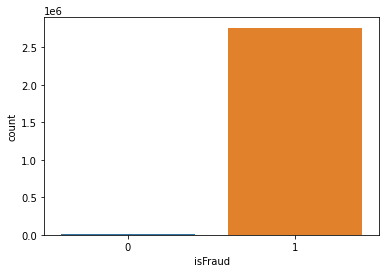

In [4]:
sns.countplot(df['isFraud'])

# Classificações

In [5]:
from sklearn.model_selection import train_test_split

x_df = df.drop('isFraud',axis=1)
y_df = df[['isFraud']]

X_treino, X_teste, y_treino, y_teste = train_test_split(x_df, y_df, test_size=0.3, random_state=42)


## Regressão Logística

### Regressão com dados desbalanceados

In [6]:
y_teste.value_counts(normalize=True)

isFraud
1          0.996997
0          0.003003
dtype: float64

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix


regLogistica = LogisticRegression(
    max_iter=200,
    class_weight={1:0.996997, 0:0.003003},
)

regLogistica.fit(X_treino, y_treino)

y_regPredicao = regLogistica.predict(X_teste)

confusion_matrix(y_teste, y_regPredicao)

array([[    10,   2486],
       [     0, 828627]])

In [8]:
from sklearn.metrics import classification_report

print(classification_report(y_teste, y_regPredicao, target_names=['Fraude', 'Nao Fraude']))

              precision    recall  f1-score   support

      Fraude       1.00      0.00      0.01      2496
  Nao Fraude       1.00      1.00      1.00    828627

    accuracy                           1.00    831123
   macro avg       1.00      0.50      0.50    831123
weighted avg       1.00      1.00      1.00    831123



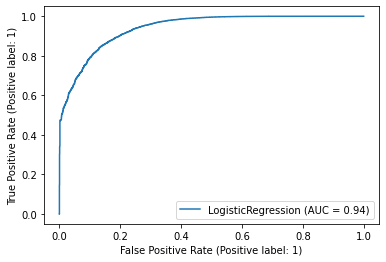

In [9]:
from sklearn.metrics import plot_roc_curve

plot_roc_curve(regLogistica, X_teste, y_teste,)
plt.show()


#### Tabela da Regressão Logística (desbalanceada)

|Estratégia		|Acurácia	|Precision	|Recall	|F1 Score	|AUC	|
|---------------|:-----------:|:-----------:|:-------:|:-----------:|-------|
|*default*		|1			|0.98		|0.58	|0.64		|0.94	|
|*auto weight*	|0.85		|0.51		|0.89	|0.48		|0.95	|
|*manual weight*	|1			|1			|0.5	|0.5		|0.94	|



### Balanceamento dos dados para a Regressão

In [10]:
from imblearn.over_sampling import ADASYN
    
overSample = ADASYN(random_state=42, sampling_strategy=0.2)
X_over, y_over = overSample.fit_resample(X_treino, y_treino)



In [11]:
print(y_treino.value_counts())
print()
print(y_over.value_counts())

isFraud
1          1933569
0             5717
dtype: int64

isFraud
1          1933569
0           386564
dtype: int64


<AxesSubplot:xlabel='isFraud', ylabel='count'>

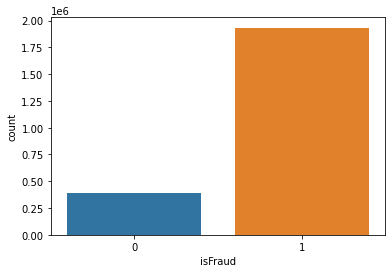

In [12]:
sns.countplot(y_over['isFraud'])

In [13]:
regPredicaoOver = LogisticRegression(
    max_iter=100,
    class_weight='balanced',
)

regPredicaoOver.fit(X_over, y_over)

y_regPredicaoOver = regPredicaoOver.predict(X_teste)

confusion_matrix(y_teste, y_regPredicaoOver)

array([[  2485,     11],
       [187339, 641288]])

In [14]:
from sklearn.metrics import classification_report

print(classification_report(y_teste, y_regPredicaoOver, target_names=['Fraude', 'Nao Fraude']))

              precision    recall  f1-score   support

      Fraude       0.01      1.00      0.03      2496
  Nao Fraude       1.00      0.77      0.87    828627

    accuracy                           0.77    831123
   macro avg       0.51      0.88      0.45    831123
weighted avg       1.00      0.77      0.87    831123



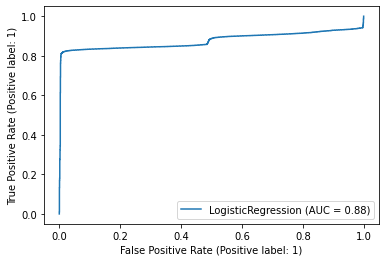

In [15]:
from sklearn.metrics import plot_roc_curve

plot_roc_curve(regPredicaoOver, X_teste, y_teste)
plt.show()

### (OVER+UNDER).SAMPLE

In [1]:
from imblearn.combine import SMOTEENN

ouCombine = SMOTEENN(
    sampling_strategy=0.5,
    random_state=42
    n_jobs=-1
)

X_comb, y_comb = ouCombine.fit_resample(X_treino, y_treino)


In [ ]:
sns.countplot(y_comb    ['isFraud'])

In [ ]:
regPredicaoComb = LogisticRegression(
    max_iter=100,
    class_weight='balanced',
)

regPredicaoComb.fit(X_comb, y_comb)

y_regPredicaoComb = regPredicaoComb.predict(X_teste)

confusion_matrix(y_teste, y_regPredicaoComb)

#### Tabela da Regressão Logística (balanceada)

|Estratégia		|Acurácia	|Precision	|Recall	|F1 Score	|AUC	|
|---------------|:-----------:|:-----------:|:-------:|:-----------:|-------|
|*default*		|0.96			|0.53		|0.82	|0.54		|0.95	|
|*auto weight*	|0.85		|0.51		|0.89	|0.48		|0.95	|
|*manual weight*	|1			|1			|0.5	|0.5		|0.94	|



## Árvore de Decisão

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

arvere = DecisionTreeClassifier(
    criterion='gini',
    class_weight='balanced',

)
arvere.fit(X_treino, y_treino)

y_arvPred = arvere.predict(X_teste)

#accuracy_score(y_teste, y_pred, normalize=True)

matrizConf = confusion_matrix(y_teste, y_arvPred)
matrizConf

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

matrizConf = confusion_matrix(y_teste, y_pred)
matrizDisplay = ConfusionMatrixDisplay(confusion_matrix=matrizConf, display_labels=arvere.classes_)
matrizDisplay.plot(values_format='d')


In [ ]:
from sklearn.metrics import precision_score, recall_score, fbeta_score


print('Precision ',precision_score(y_teste, y_pred, pos_label=0))
print('Recall ', recall_score(y_teste, y_pred, pos_label=0))
print('F1', fbeta_score(y_teste, y_pred, beta=1, pos_label=0))

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_teste, y_pred, target_names=['Fraude', 'Nao Fraude']))

In [ ]:
'''
export_graphviz(
    arvere,
    out_file=('arvere.dot'),
    feature_names=X_treino.columns,
    rounded=True,
    filled=True
)

!dot -Tpng arvere.dot -o iris_tree.png
'''

## XGBoost